In [1]:
from diagonal_bilstm import DiagonalBiLSTM
from flax import nnx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import treescope
import tqdm
import os
treescope.register_as_default()

In [2]:

# downloaded from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dataset_path = '/home/apoorv/Projects/datasets/cifar-10-batches-py/'

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_batches = []
for i in range(1, 6):
    file_path = os.path.join(dataset_path, f'data_batch_{i}')
    batch = unpickle(file_path)
    cifar10_batches.append(batch)

cifar10_test_batches = []
file_path = os.path.join(dataset_path, 'test_batch')
test_batch = unpickle(file_path)
cifar10_test_batches.append(test_batch)


In [3]:
def get_images(cifar10_batches):
    data = []
    labels = []
    for batch in cifar10_batches:
        images = batch[b'data']
        images = images.reshape(images.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
        data.append(images)
        labels.append(batch[b'labels'])
    data = np.row_stack(data)
    return data, labels

In [4]:
data, labels = get_images(cifar10_batches)
test_data, test_labels = get_images(cifar10_test_batches)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def display_image_grid(images, grid_shape):
    assert images.shape[0] == grid_shape[0] * grid_shape[1]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=grid_shape)
    fig.patch.set_facecolor('black') # Set background to black for better contrast
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        img_to_show = images[i]
        ax.imshow(img_to_show)
        ax.axis('off') # Hide the x and y axes
    plt.show()

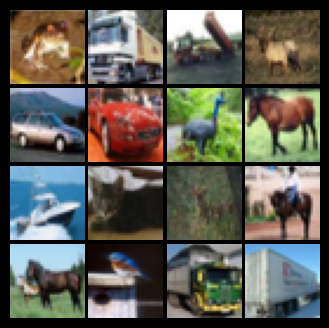

In [6]:
display_image_grid(data[:16], (4, 4))

In [7]:
class Batcher:
    def __init__(self, images, batch_size):
        self.images = images
        self.bsz = batch_size
        self.iter = 0
    
    def get_batch(self):
        if (self.iter + 1) * self.bsz < self.images.shape[0]:
            start_idx = self.iter * self.bsz
            end_idx = (self.iter + 1) * self.bsz
            self.iter += 1
            return self.images[start_idx: end_idx].astype(jnp.uint8)
        else:
            self.shuffle()
            return self.get_batch()
    
    def shuffle(self):
        self.images = np.random.shuffle(self.images)
        self.iter = 0

In [8]:
def compute_loss(model, image_batch):
    labels = nnx.one_hot(image_batch, 256)
    logits_bmncd = model(image_batch)

    loss = 0
    for i in range(3):
        loss += optax.softmax_cross_entropy(logits_bmncd[:, :, :, i], labels[:, :, :, i])

    loss = jnp.mean(jnp.mean(loss, axis=[1, 2]))
    return loss

def compute_accuracy(logits_bmncd, image_batch):
    red_accuracy = jnp.argmax(logits_bmncd[:, :, :, 0], axis=-1) == image_batch[:, :, :, 0]
    green_accuracy = jnp.argmax(logits_bmncd[:, :, :, 1], axis=-1) == image_batch[:, :, :, 1]
    blue_accuracy = jnp.argmax(logits_bmncd[:, :, :, 2], axis=-1) == image_batch[:, :, :, 2]

    top1_accuracy = red_accuracy & green_accuracy & blue_accuracy
    top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))

def compute_nll(logits_bmncd, im_bmnc):
    # logits_bmnh , where h = 3*256
    # compute negative log-likelihood of a batch
    logprob_bmn = 0
    for i in range(3):
        logprob_bmnd = nnx.log_softmax(logits_bmncd[:,:,:,i])
        logprob_bmn += logprob_bmnd[im_bmnc[:,:,:,i]]
    return -jnp.mean(jnp.sum(logprob_bmn, axis=[1, 2]))

@nnx.jit
def train_step(model, optimizer, batch):
    grad_fn = nnx.value_and_grad(compute_loss)
    loss, grads = grad_fn(model, batch)
    optimizer.update(grads)
    return loss

def compute_metrics(model, image_batch):
    labels = nnx.one_hot(image_batch, 256)
    logits_bmncd = model(image_batch)

    loss = 0
    for i in range(3):
        loss += optax.softmax_cross_entropy(logits_bmncd[:, :, :, i], labels[:, :, :, i])
    loss = jnp.mean(jnp.mean(loss, axis=[1, 2]))

    top1_accuracy = compute_accuracy(logits_bmncd, image_batch)
    
    nll = compute_nll(logits_bmncd, image_batch)

    return loss, top1_accuracy, nll

@nnx.jit()
def eval_step(model, batch, eval_metrics):
    loss, top1_accuracy, nll = compute_metrics(model, batch)

    eval_metrics.update(
        loss=loss,
        accuracy=top1_accuracy,
        nll=nll
    )

loss[0]: 18.948867797851562
loss[1]: 17.549781799316406
loss[2]: 17.04140853881836
loss[3]: 16.810087203979492
loss[4]: 16.690601348876953
loss[5]: 16.623825073242188
loss[6]: 16.588489532470703
loss[7]: 16.563140869140625
loss[8]: 16.543933868408203
loss[9]: 16.5275936126709
loss[10]: 16.506908416748047
loss[11]: 16.48405647277832
loss[12]: 16.46060562133789
loss[13]: 16.435161590576172
loss[14]: 16.411052703857422
loss[15]: 16.388038635253906
loss[16]: 16.36357307434082
loss[17]: 16.33172607421875
loss[18]: 16.30530548095703
loss[19]: 16.276813507080078
loss[20]: 16.246423721313477
loss[21]: 16.2166690826416
loss[22]: 16.184764862060547
loss[23]: 16.150318145751953
loss[24]: 16.116809844970703
loss[25]: 16.0832576751709
loss[26]: 16.048919677734375
loss[27]: 16.013690948486328
loss[28]: 15.976818084716797
loss[29]: 15.941228866577148
loss[30]: 15.903100967407227
loss[31]: 15.866090774536133
loss[32]: 15.822509765625
loss[33]: 15.779560089111328
loss[34]: 15.737489700317383
loss[35]: 

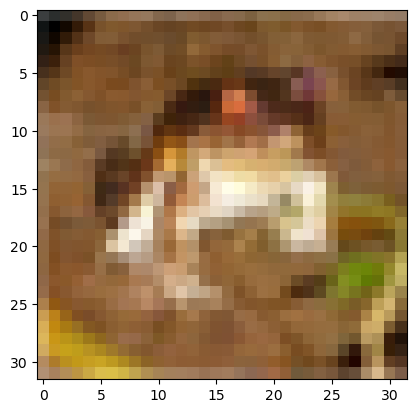

In [14]:
batcher = Batcher(data, 1)
batch = batcher.get_batch()

plt.imshow(batch[0])

# model hypers
features = 64
num_layers = 1
is_rgb = True
preds_dim = 256
enable_skip_connections = True

rngs = nnx.Rngs(params=0)
model = DiagonalBiLSTM(features=features,
                       num_layers=num_layers,
                       is_rgb=is_rgb,
                       preds_dim=preds_dim,
                       enable_skip_connections=enable_skip_connections,
                       rngs=rngs)

grad_clip = 1.0
optimizer = nnx.Optimizer(
    model,
    optax.chain(
        optax.clip_by_global_norm(grad_clip),
        optax.adam(learning_rate=1.5e-3)
    )
)

for i in range(2000):
    loss = train_step(model, optimizer, batch)
    print(f"loss[{i}]: {loss}")

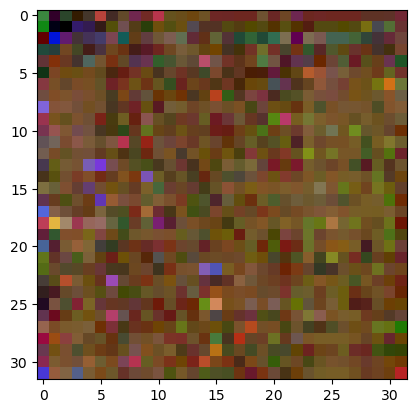

In [15]:
gen_image_batch = model.generate(32, 32, 1, jax.random.key(123))
plt.imshow(gen_image_batch[0].astype(np.uint8))

In [ ]:
plt.imshow(model(batch).argmax(axis=-1)[0])

## Train on entire CIFAR10

In [ ]:
import wandb
wandb.login()

In [ ]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
batch_size = 64
train_total_steps = data.shape[0] // batch_size
num_epochs = 100
eval_total_steps = test_data.shape[0] // batch_size


eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Average('accuracy'),
    nll=nnx.metrics.Average('nll')
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
    "test_nll": []
}

def train_one_epoch(epoch, model, optimizer):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        batcher = Batcher(data, batch_size)
        batcher.shuffle()
        for i in range(train_total_steps):
            batch = batcher.get_batch()
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            wandb.log({"train_loss": loss.item(), "samples": epoch * train_total_steps * batch_size + (i+1) * batch_size})
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch, model):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics
    with tqdm.tqdm(
        desc=f"[eval] epoch: {epoch}/{num_epochs}, ",
        total=eval_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        eval_metrics.reset()  # Reset the eval metrics
        batcher = Batcher(test_data, batch_size)
        for i in range(eval_total_steps):
            batch = batcher.get_batch()
            eval_step(model, batch, eval_metrics)
            pbar.update(1)

        for metric, value in eval_metrics.compute().items():
            wandb.log({f'test_{metric}': value})
            eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[eval] epoch: {epoch}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")
    print(f"- NLL: {eval_metrics_history['test_nll'][-1]:0.4f}")